In [10]:
import numpy as np
import zen
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
def katz(G,tol=0.01,max_iter=1000,alpha=0.001,beta=1):
    iteration = 0
    centrality = np.zeros(G.num_nodes)
    while iteration < max_iter:
        iteration += 1          # increment iteration count
        centrality_old = centrality.copy()

        for node in G.nodes_():
            Ax = 0
            for neighbor in G.neighbors_(node):
                weight = G.weight_(G.edge_idx_(neighbor,node))
                Ax += np.multiply(centrality[neighbor],weight)

                #Ax += centrality[neighbor]      #exclude weight due to overflow in multiplication

            centrality[node] = np.multiply(alpha,Ax)+beta

        if np.sum(np.abs(np.subtract(centrality,centrality_old))) < tol:
            return centrality
def modularity(G,classDict,classList):
    Q = zen.algorithms.modularity(G,classDict)
    # Maximum Modularity
    count=0.0
    for e in G.edges():
        n1 = G.node_idx(e[0])
        n2 = G.node_idx(e[1])
        if classList[n1] == classList[n2]:
            count += 1
    same = count / G.num_edges
    rand = same - Q
    qmax = 1 - rand
    return Q, qmax

In [12]:
def MSE(x,y,m):
    '''
    Not mean-squared-error, just too lazy to chance the function name.
    Measures the orthogonal distance points are from the line through origin with slope m
    '''
    x_ = (m*y+x)/(m**2 + 1)
    y_ = (y*(m**2) + m*x)/(m**2 + 1)
    return np.sum(np.power(x-x_,2) + np.power(y-y_,2))
    

def slope(angle):
    '''
    Calculates linear slope of line with angle from x-axis (radians)
    '''
    return np.tan(angle)
    
def bound(x, y, slope, lineU, lineL):
    '''
    returns subset of x,y that are between the lines lineU and lineL
    '''
    upper = lineU(x,slope)
    lower = lineL(x,slope)
    return np.logical_and(y>=lower, y<=upper)

def get_offsets(m,d):
    '''
    calculates the shift of a line that has an orthogonal distance d
    from a line through the origin with slope m
    '''
    A = 1./(m**2) + 1
    B = -2*A
    C = (1./(m**2))+1 - d**2
    
    x1 = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)
    
    y1 = m + (1./m) - (x1/m)
    
    b1 = y1 - m*x1
    return b1

def lineFinder(x, y, dtheta=0.01, dx=0.05):
    theta=0
    
    line = lambda x,m: m*x
    b_up = lambda x,m: m*(x)-get_offsets(m,dx)
    b_low= lambda x,m: m*(x)+get_offsets(m,dx)
    
    thetas = np.arange(1e-4,np.pi/2,dtheta)
    error = np.empty(len(thetas))
    
    for i,theta in enumerate(thetas):
        m = slope(theta)
        X = x[bound(x,y,m,b_up,b_low)]
        Y = y[bound(x,y,m,b_up,b_low)]
        error[i] = MSE(X,Y,m)*(len(X)/float(len(x)))
    
    return thetas, error

def optimizeAngles(angle,error,N,plot=False):
    N=10
    x = pd.Series(error).rolling(window=N).mean().iloc[N-1:].values
    x_ = np.diff(x)
    t = angle[N:]
    ang = []
    for i in range(len(x_)):
        if i != 0 and i != len(x_)-1:
            if x_[i-1] < 0 and x_[i] >= 0:
                ang.append(t[i])
    if plot:
        for a in ang:
            plt.vlines(ymin=np.min(x),ymax=np.max(x),x=a*180/np.pi,linestyle='--',color='grey')
        plt.plot(angle[N-1:]*180/np.pi,x)
        plt.xlabel('Angle (deg.)')
        plt.ylabel('Sum of Squared Orth. Error')
        plt.title('Identification of Local Minima')
        plt.show()

    return ang

def getGroups(x,y,angles):
    if len(angles) == 1:
        m = slope(angles[0])
        y_ = x*m
        g1 = np.where(y<=y_)[0]
        g2 = np.where(y>y_)[0]
        return [g1,g2]
    elif len(angles) == 2:
        m1 = slope(angles[0])
        m2 = slope(angles[1])
        y1_ = x*m1
        y2_ = x*m2
        g1 = np.where(y<=y1_)[0]
        g2 = np.where(np.logical_and(y>y1_,y<=y2_))[0]
        g3 = np.where(y>y2_)[0]
        return [g1,g2,g3]

In [13]:
def lineClustering(x,y, dtheta=0.01, dx=0.05, window=10, plot=False):
    angles, errors = lineFinder(x,y,dtheta=dtheta,dx=dx)
    best_angles = optimizeAngles(angles,errors,window,plot=plot)
    clusters = getGroups(x,y,best_angles)
    return clusters

In [14]:
G = zen.io.gml.read('amazon_product.gml',weight_fxn=lambda x: x['weight'])

evc = zen.algorithms.eigenvector_centrality_(G)
kc = katz(G,alpha=1e-4)
evc = evc - np.min(evc)
evc = evc / np.max(evc)
kc  = kc - np.min(kc)
kc = kc / np.max(kc)

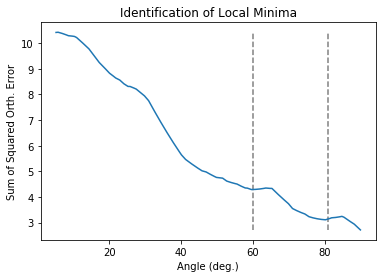

In [15]:
clusters = lineClustering(evc,kc,dx=0.5,plot=True)

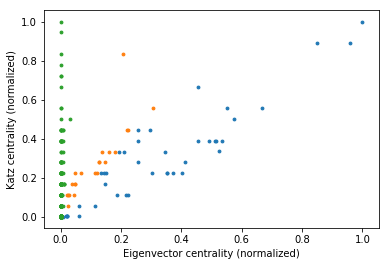

In [19]:
for c in clusters:
    plt.scatter(evc[c],kc[c],s=8)
plt.xlabel('Eigenvector centrality (normalized)')
plt.ylabel('Katz centrality (normalized)')
plt.show()

In [17]:
ClassDict = {}
for i,c in enumerate(clusters):
    ClassDict[i] = [G.node_object(x) for x in c]

ClassList = np.zeros(G.num_nodes)
for i,c in enumerate(clusters):
    ClassList[c[i]]=i

q,qmax = modularity(G,ClassDict,ClassList)
print 'Normalized Q: %.3f'%(q/qmax)

Normalized Q: 0.968
